In [1]:
import requests

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


In [55]:
CLIENT_ID = 'no' # your Foursquare ID
CLIENT_SECRET = 'no' # your Foursquare Secret
VERSION = '20190101' # Foursquare API version
categoryID = '4d4b7105d754a06374d81259' #Food
LIMIT = 50

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: no
CLIENT_SECRET:no


In [134]:
# function that extracts the category of the venue
def getVenueRating(venue):
    try:
        rating = venue['response']['venue']['rating']
    except:
        rating = 0
    return rating
    
def getNearbyVenues(latitudes, longitudes,venueCategory, radius=600):
    
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):
        print('Executing lat={},lng={}'.format(lat,lng))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?intent=browse&categoryid={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            venueCategory,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT) 
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        for v in results:
            venue = requests.get('https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(v['venue']['id'],CLIENT_ID, CLIENT_SECRET, VERSION)).json()
            #print(v['venue']['name'])
            #print(venue)
            rating = getVenueRating(venue)
            venues_list.append([
                v['venue']['id'],
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'],
                rating])
               

    
    return(venues_list)

In [19]:
lat = [44.014445,44.014396,44.006656,44.008766,44.001346,44.004062,43.996407,43.996666]
lon = [12.634616,12.643378,12.640065,12.651550,12.649506,12.661351,12.656029,12.667747]

In [2]:
test_riccione = getNearbyVenues(lat,lon,categoryID)

In [138]:
labels = ['id', 'name', 'lat', 'lng','category','rating']
df = pd.DataFrame.from_records(test_riccione, columns=labels)
df_bck = df = pd.DataFrame.from_records(test_riccione, columns=labels)

In [139]:
df.shape

(275, 6)

In [143]:
df.drop_duplicates(subset=None, keep='first', inplace=True)
df.shape

(207, 6)

In [147]:
df.to_csv(path_or_buf='foursquare_riccione_new.csv',index=False)

## Reading from csv after api

In [2]:
df = pd.read_csv('foursquare_riccione_new.csv')
df.head()

,id,name,lat,lng,category,rating
0,4d961809af3d236ab4ca01c7,Locanda Della Luna,44.011014,12.632975,Italian Restaurant,8.1
1,4de7dac37d8b1f2dd2a27ac2,La Fattoria Del Mare,44.016893,12.641178,Italian Restaurant,7.9
2,4c1874ca834e2d7f7fef2880,Caffe Bianchi,44.017625,12.639859,Breakfast Spot,7.6
3,4ca7a7eff47ea143281c6d21,Ristorante Pizzeria Portofino,44.010952,12.639242,Pizza Place,7.1
4,57000eef498ec76a5112e2c0,El Mexicali,44.019430,12.637160,Mexican Restaurant,7.2


In [3]:
filtered_classes=['Park','Beach','Plaza','Multiplex','Arcade']
df = df[~df['category'].isin(filtered_classes)]
df.shape

(190, 6)

In [4]:
# create map of Manhattan using latitude and longitude values
ricc_lat = 43.994801
ricc_lon = 12.653507
map_riccione = folium.Map(location=[ricc_lat, ricc_lon], zoom_start=13)

# add markers to map
for lat, lng, name, category, rating in zip(df['lat'], df['lng'], df['name'],df['category'],df['rating']):
    label = folium.Popup('Name: {} - Category: {} - Rating: {}'.format(name,category,rating) , parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_riccione)  
    
map_riccione

# Transform, Cluster and see what's going on

In [5]:
df_transformed = df[['lat','lng','rating']]
df_transformed.head()

,lat,lng,rating
0,44.011014,12.632975,8.1
1,44.016893,12.641178,7.9
2,44.017625,12.639859,7.6
3,44.010952,12.639242,7.1
4,44.019430,12.637160,7.2


In [6]:
df_transformed['x'] = np.cos(df_transformed['lat']) * np.cos(df_transformed['lng'])
df_transformed['y'] = np.cos(df_transformed['lat']) * np.sin(df_transformed['lng'])
df_transformed['z'] = np.sin(df_transformed['lat'])

scaler = MinMaxScaler()
df_transformed[['x','y','z','rating']] = scaler.fit_transform(df_transformed[['x','y','z','rating']])
df_transformed.drop(columns=['lat','lng'],inplace=True)
df_transformed.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,rating,x,y,z
0,0.757576,0.949501,0.073534,0.673745
1,0.696970,0.716619,0.263543,0.901648
2,0.606061,0.738580,0.232907,0.930040
3,0.454545,0.817111,0.218970,0.671363
4,0.484848,0.777917,0.170197,1.000000


### Clustering

In [7]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k,random_state=0)
    km = km.fit(df_transformed)
    Sum_of_squared_distances.append(km.inertia_)

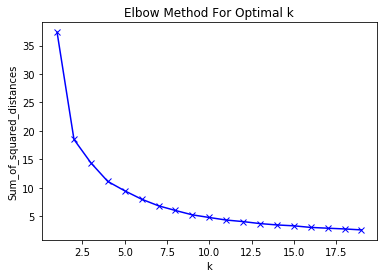

In [8]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [16]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_transformed)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 1, 3, 3, 3, 3, 3, 3], dtype=int32)

In [34]:
df.drop(columns=['ClusterLabels'],inplace=True)
df.insert(0, 'ClusterLabels', kmeans.labels_)
df.head()

,ClusterLabels,id,name,lat,lng,category,rating
0,1,4d961809af3d236ab4ca01c7,Locanda Della Luna,44.011014,12.632975,Italian Restaurant,8.1
1,3,4de7dac37d8b1f2dd2a27ac2,La Fattoria Del Mare,44.016893,12.641178,Italian Restaurant,7.9
2,3,4c1874ca834e2d7f7fef2880,Caffe Bianchi,44.017625,12.639859,Breakfast Spot,7.6
3,1,4ca7a7eff47ea143281c6d21,Ristorante Pizzeria Portofino,44.010952,12.639242,Pizza Place,7.1
4,3,57000eef498ec76a5112e2c0,El Mexicali,44.019430,12.637160,Mexican Restaurant,7.2


In [35]:
# create map
map_clusters = folium.Map(location=[ricc_lat, ricc_lon], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, rating, category, cluster in zip(df['lat'], df['lng'], df['name'],df['rating'],df['category'] , df['ClusterLabels']):
    label = folium.Popup('Name: {} - Category: {} - Rating: {} - Cluster: {}'.format(name,category,rating, cluster) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Finding Clusters with average rank < 7

In [45]:
df.groupby(['ClusterLabels'])['rating'].mean()

ClusterLabels
0    7.196154
1    7.327273
2    6.821429
3    7.350000
4    7.309091
5    8.318182
6    6.729630
Name: rating, dtype: float64

#### We find out that cluster 2 and cluster 6 (Blue and Orange on the map) have an average rating below 7, which means that people have diverging opinions on the place. Let's find out where are then the best two places where we want to open our restaurant!

In [51]:
clusters = df[df['ClusterLabels'].isin([2,6])].groupby(['ClusterLabels'])['lat','lng'].mean()
clusters.head()

,lat,lng
ClusterLabels,,
2,43.996635,12.654191
6,44.008094,12.651183


### Printing the result

In [54]:
# create map
map_clusters = folium.Map(location=[ricc_lat, ricc_lon], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, rating, category, cluster in zip(df['lat'], df['lng'], df['name'],df['rating'],df['category'] , df['ClusterLabels']):
    label = folium.Popup('Name: {} - Category: {} - Rating: {} - Cluster: {}'.format(name,category,rating, cluster) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

for lat, lon in zip(clusters['lat'], clusters['lng']):
    label = folium.Popup('Place your Restaurant Here!')
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='#000000',
        fill=True,
        fill_color='#684040',
        fill_opacity=0.7).add_to(map_clusters)    
    
map_clusters